In [49]:
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import re
from os import listdir
from os.path import isfile, join
from datasets import load_dataset

## Data

In [4]:
# translation data https://aclanthology.org/2005.mtsummit-papers.11/
languages = 'da de el en es fr fi it nl pt sv'
bleu_data = \
'''- 18.4 21.1 28.5 26.4 28.7 14.2 22.2 21.4 24.3 28.3
22.3 - 20.7 25.3 25.4 27.7 11.8 21.3 23.4 23.2 20.5
22.7 17.4 - 27.2 31.2 32.1 11.4 26.8 20.0 27.6 21.2
25.2 17.6 23.2 - 30.1 31.1 13.0 25.3 21.0 27.1 24.8
24.1 18.2 28.3 30.5 - 40.2 12.5 32.3 21.4 35.9 23.9
23.7 18.5 26.1 30.0 38.4 - 12.6 32.4 21.1 35.3 22.6
20.0 14.5 18.2 21.8 21.1 22.4 - 18.3 17.0 19.1 18.8
21.4 16.9 24.8 27.8 34.0 36.0 11.0 - 20.0 31.2 20.2
20.5 18.3 17.4 23.0 22.9 24.6 10.3 20.0 - 20.7 19.0
23.2 18.2 26.4 30.1 37.9 39.0 11.9 32.0 20.2 - 21.9
30.3 18.9 22.8 30.2 28.6 29.7 15.3 23.9 21.9 25.9 -'''

df_bleu = pd.DataFrame([r.split(' ') for r in bleu_data.split('\n')], dtype=float, columns=languages.split(' '), index=languages.split(' '))
df_bleu

,da,de,el,en,es,fr,fi,it,nl,pt,sv
da,-,18.4,21.1,28.5,26.4,28.7,14.2,22.2,21.4,24.3,28.3
de,22.3,-,20.7,25.3,25.4,27.7,11.8,21.3,23.4,23.2,20.5
el,22.7,17.4,-,27.2,31.2,32.1,11.4,26.8,20.0,27.6,21.2
en,25.2,17.6,23.2,-,30.1,31.1,13.0,25.3,21.0,27.1,24.8
es,24.1,18.2,28.3,30.5,-,40.2,12.5,32.3,21.4,35.9,23.9
fr,23.7,18.5,26.1,30.0,38.4,-,12.6,32.4,21.1,35.3,22.6
fi,20.0,14.5,18.2,21.8,21.1,22.4,-,18.3,17.0,19.1,18.8
it,21.4,16.9,24.8,27.8,34.0,36.0,11.0,-,20.0,31.2,20.2
nl,20.5,18.3,17.4,23.0,22.9,24.6,10.3,20.0,-,20.7,19.0
pt,23.2,18.2,26.4,30.1,37.9,39.0,11.9,32.0,20.2,-,21.9


In [145]:
languages_3cd = 'dan deu ell eng spa fra fin ita nld por swe'.split()
df_spbleu = pd.read_csv('translation_scores.csv', index_col=0, sep=' ')
df_spbleu = df_spbleu[languages_3cd].loc[languages_3cd]
df_spbleu.columns = languages.split()
df_spbleu.index = languages.split()
df_spbleu

,da,de,el,en,es,fr,fi,it,nl,pt,sv
da,-,31.29,23.63,41.08,24.05,36.95,24.27,25.8,26.32,35.93,39.45
de,34.07,-,22.76,35.83,23.35,35.47,22.57,25.86,25.83,34.03,33.16
el,25.15,21.93,-,28.12,20.69,30.17,18.21,21.71,19.48,28.42,23.98
en,41.12,32.56,26.19,-,25.57,41.99,24.23,27.74,26.82,44.84,40.23
es,24.82,21.04,20.61,25.09,-,29.33,17.9,23.87,19.52,28.1,23.1
fr,32.96,28.53,23.88,37.17,25.6,-,21.86,28.56,24.51,37.84,31.36
fi,26.6,23.04,19.73,27.16,19.93,29.29,-,21.02,21.52,27.49,27.25
it,27.56,24.2,22.09,28.74,24.52,34.39,19.46,-,21.99,31.47,26.42
nl,26.15,23.06,18.89,27.7,19.8,28.82,18.65,21.33,-,26.93,25.54
pt,33.82,28.38,24.65,41.53,26.88,40.17,22.28,28.09,24.49,-,32.68


In [7]:
# bible corpus https://github.com/christos-c/bible-corpus
def bible_sentences(lang):
    with open(f"bible_xml/{lang}.txt", 'r') as f:
        data = f.read()

    data = re.sub('[0-9/\-\(\):;,.?!"]', '', data) # no special chars
    data = data.lower().split('\n')
    return data
    
def bible_words(lang):
    text = ' '.join(bible_sentences(lang))
    words = text.split(' ')
    return words

len(bible_words('en'))

789638

In [44]:
# europarl corpus https://www.statmt.org/europarl/archives.html
def _europarl_filenames(lang):
    base_path = f"europarl/txt/{lang}/"
    files = [base_path+f for f in listdir(base_path) if isfile(join(base_path, f))]
    files = sorted(files)
    return files

def europarl_sentences(lang):
    files = _europarl_filenames(lang)
    all_data = []
    for f in files:
        with open(f, 'r') as f:
            data = f.read()

        data = re.sub('<[^<]+?>', '', data) # remove tags

        data = re.sub('[0-9/!?]', '.', data) # end of sentence
        data = re.sub('[0-9/\-\(\):,"]', '', data) # no special chars
        data = data.lower().split('.')
        all_data += data
    return all_data
    
def europarl_words(lang):
    text = ' '.join(europarl_sentences(lang))
    words = text.split(' ')
    return words

len(europarl_words('en'))

53242896

In [54]:
# oscar open-crawled-corpus https://huggingface.co/datasets/oscar
def oscar_sentences(lang, max_sentences=20000):
    sentences = []
    d = load_dataset("oscar", language=lang, streaming=True)
    for data in d['train']:
        text = data['text']
        text = re.sub('[0-9]/\-\(\):;,\n"]', '', text) # no special chars
        text = re.sub('[!?]', '.', text) # end of sentence
        sentences += text.lower().split('.')
        if len(sentences)>max_sentences:
            break
    return sentences
    
def oscar_words(lang):
    text = ' '.join(oscar_sentences(lang))
    words = text.split(' ')
    return words

len(oscar_words('en'))

Using custom data configuration unshuffled_deduplicated_en-language=en


409958

## Entropy Estimators

In [8]:
# nsb entropy (iid)
# https://gist.github.com/shhong/1021654
import nsb_entropy as nsb

def nsb_entropy(corp,
                ):
    # build histogram
    vocab = {w:i for i,w in enumerate(set(corp))}
    
    hist = np.zeros(len(vocab))
    for w in corp: # words
        hist[vocab[w]] += 1

    nxkx = nsb.make_nxkx(hist, len(hist))
    H = nsb.S(nxkx, hist.sum(), len(nxkx))
    return H
    
nsb_entropy(bible_words('en')[:1000])

25.89570735529012092031427306969148387328

In [28]:
# source entropy (increasing window)
# https://www.dam.brown.edu/people/elie/papers/Gao%20Kontoyiannis%20Bienenstock%20Estimating%20the%20entropy%20of%20binary%20time%20series.pdf

def lz_entropy(corp,
               ):
    ls = 0
    for i in range(1,len(corp)): # for each position
        l = 1
        for j in range(i): # increasing window
            lj = 0
            # while lj<window_size and corp[(i+lj)%len(corp)]==corp[(j+lj)%len(corp)]: # wraps around
            while (i+lj<len(corp)) and (corp[i+lj]==corp[j+lj]): 
                lj += 1
            l = max(l, lj+1)
        ls += l / np.log(i+1)
    H = len(corp)/ls 
    return H

lz_entropy(bible_words('en')[:1000])

1.7992598784580365

In [146]:
# fn for getting entropies and entropy ratios
def calculate_entropy(corp_fn, h_fn, n_words, kwargs={}):
    lang_h = {}
    for lang in languages.split():
        corp = corp_fn(lang)[:n_words]
        lang_h[lang] = h_fn(corp, **kwargs)
        
    h_r = []
    for l1 in languages.split():
        for l2 in languages.split():
            if l1 != l2:
                h_r.append(lang_h[l2] / lang_h[l1])

    return lang_h, np.array(h_r).astype(float)

# machine translation 
bleu, spbleu = [], []
for l1 in languages.split():
    for l2 in languages.split():
        if l1 != l2:
            bleu.append(float(df_bleu[l1][l2]))
            spbleu.append(float(df_spbleu[l1][l2]))
bleu = np.array(bleu).astype(float)
spbleu = np.array(spbleu).astype(float)

In [30]:
# recreate paper results
# https://arxiv.org/pdf/1606.06996.pdf
nsb_bib_h, nsb_bib_r = calculate_entropy(bible_words, nsb_entropy, n_words=50000)
lz_bib_h, lz_bib_r = calculate_entropy(bible_words, lz_entropy, n_words=50000)

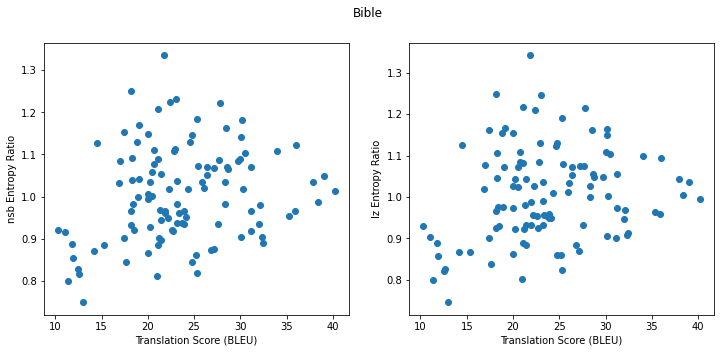

bleu,   nsb    : r= 0.2206436788924921
bleu,   lz     : r= 0.209293763950709

spbleu, nsb    : r= 0.09771377832839717
spbleu, lz     : r= 0.08595298923225952


,nsb,lz
nsb,1.00000,0.99283
lz,0.99283,1.00000


In [148]:
def entropy_entropy_ratio(hs):
    df_h = pd.DataFrame({n:[float(h[l]) for l in languages.split()] for n,h in hs})
    display(df_h.corr())

def entropy_bleu_ratio(rs, corpus_nm):    
    fig, axs = plt.subplots(1, len(rs), figsize=(6*len(rs),5))
    if len(rs)==1:
        axs = [axs]
    for ax, (n,r) in zip(axs, rs):
        ax.scatter(bleu, r)
        ax.set_xlabel('Translation Score (BLEU)')
        ax.set_ylabel(f'{n} Entropy Ratio')
    fig.suptitle(corpus_nm)
    plt.show()
    
    for n,r in rs:
        print(f'bleu,   {n:<6} : r=',np.corrcoef(bleu, r)[0,1])
    print()
    for n,r in rs:
        print(f'spbleu, {n:<6} : r=',np.corrcoef(spbleu, r)[0,1])
    
entropy_bleu_ratio([('nsb',nsb_bib_r),('lz',lz_bib_r)], 'Bible')
entropy_entropy_ratio([('nsb',nsb_bib_h),('lz',lz_bib_h)])

In [45]:
nsb_eur_h, nsb_eur_r = calculate_entropy(europarl_words, nsb_entropy, n_words=50000)
lz_eur_h, lz_eur_r = calculate_entropy(europarl_words, lz_entropy, n_words=50000)

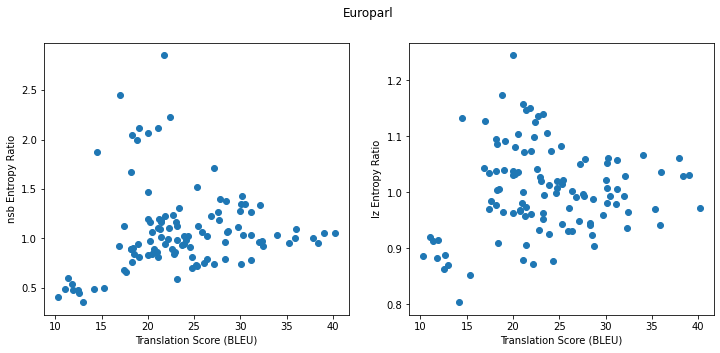

bleu,   nsb    : r= 0.11590144610602178
bleu,   lz     : r= 0.1186182146770187

spbleu, nsb    : r= 0.03265448798222369
spbleu, lz     : r= 0.055267527518202963


,nsb,lz
nsb,1.000000,0.730653
lz,0.730653,1.000000


In [149]:
entropy_bleu_ratio([('nsb',nsb_eur_r),('lz',lz_eur_r)], 'Europarl')
entropy_entropy_ratio([('nsb',nsb_eur_h),('lz',lz_eur_h)])

In [55]:
nsb_osc_h, nsb_osc_r = calculate_entropy(oscar_words, nsb_entropy, n_words=50000)
lz_osc_h, lz_osc_r = calculate_entropy(oscar_words, lz_entropy, n_words=50000)

Using custom data configuration unshuffled_deduplicated_da-language=da
Using custom data configuration unshuffled_deduplicated_de-language=de
Using custom data configuration unshuffled_deduplicated_el-language=el
Using custom data configuration unshuffled_deduplicated_en-language=en
Using custom data configuration unshuffled_deduplicated_es-language=es
Using custom data configuration unshuffled_deduplicated_fr-language=fr
Using custom data configuration unshuffled_deduplicated_fi-language=fi
Using custom data configuration unshuffled_deduplicated_it-language=it
Using custom data configuration unshuffled_deduplicated_nl-language=nl
Using custom data configuration unshuffled_deduplicated_pt-language=pt
Using custom data configuration unshuffled_deduplicated_sv-language=sv
Using custom data configuration unshuffled_deduplicated_da-language=da
Using custom data configuration unshuffled_deduplicated_de-language=de
Using custom data configuration unshuffled_deduplicated_el-language=el
Using 

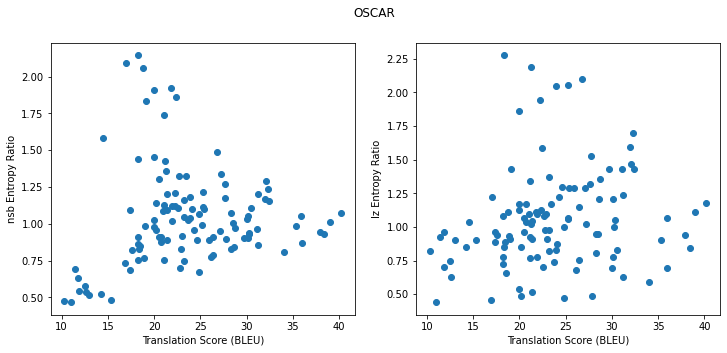

bleu,   nsb    : r= 0.0926970112091601
bleu,   lz     : r= 0.16289604202404487

spbleu, nsb    : r= 0.013537367159539564
spbleu, lz     : r= 0.045116246211754286


,nsb,lz
nsb,1.000000,0.539895
lz,0.539895,1.000000


In [150]:
entropy_bleu_ratio([('nsb',nsb_osc_r),('lz',lz_osc_r)], 'OSCAR')
entropy_entropy_ratio([('nsb',nsb_osc_h),('lz',lz_osc_h)])

## Other Entropy Related Quantities

In [75]:
def calculate_length(corp_fn):
    lens = {}
    for lang in languages.split():
        corp = corp_fn(lang)
        ls = [len(x.split()) for x in corp]
        l = sum(ls)/len(ls)
        lens[lang] = l

    len_r = []
    for l1 in languages.split():
        for l2 in languages.split():
            if l1 != l2:
                len_r.append(lens[l1] / lens[l2])
    return lens, len_r

In [76]:
bib_len, bib_len_r = calculate_length(bible_sentences)
eur_len, eur_len_r = calculate_length(europarl_sentences)
osc_len, osc_len_r = calculate_length(oscar_sentences)

Using custom data configuration unshuffled_deduplicated_da-language=da
Using custom data configuration unshuffled_deduplicated_de-language=de
Using custom data configuration unshuffled_deduplicated_el-language=el
Using custom data configuration unshuffled_deduplicated_en-language=en
Using custom data configuration unshuffled_deduplicated_es-language=es
Using custom data configuration unshuffled_deduplicated_fr-language=fr
Using custom data configuration unshuffled_deduplicated_fi-language=fi
Using custom data configuration unshuffled_deduplicated_it-language=it
Using custom data configuration unshuffled_deduplicated_nl-language=nl
Using custom data configuration unshuffled_deduplicated_pt-language=pt
Using custom data configuration unshuffled_deduplicated_sv-language=sv


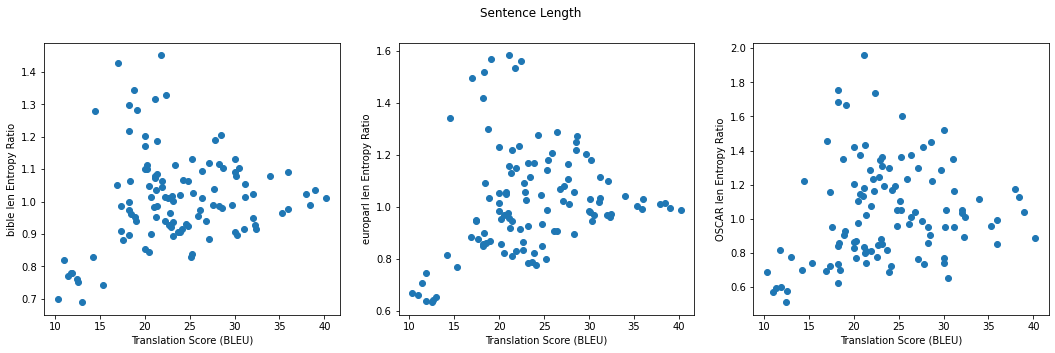

bleu,   bible len : r= 0.17401564382778745
bleu,   europarl len : r= 0.21499752589798202
bleu,   OSCAR len : r= 0.18113053476321642

spbleu, bible len : r= 0.06688589857950486
spbleu, europarl len : r= 0.09207408442004769
spbleu, OSCAR len : r= 0.06323536776827232


In [151]:
entropy_bleu_ratio([('bible len',bib_len_r),('europarl len',eur_len_r),('OSCAR len',osc_len_r),], 'Sentence Length')

In [91]:
from gensim.models import Word2Vec

def _w2v_loss(corp,
              vec_size=20,
              epochs=5,
              min_count=5,
              ):
    w2v = Word2Vec(vector_size=vec_size, window=5, min_count=4, sg=1)
    w2v.build_vocab(corp)  # prepare the model vocabulary
    w2v.train(corp, total_examples=len(corp), epochs=epochs, compute_loss=True)  # train word vectors
    return w2v.get_latest_training_loss()

def w2v_loss(corp_fn, n_sentences=10000):
    lang_l = {}
    for lang in languages.split():
        corp = [x.split() for x in corp_fn(lang)[:n_sentences]]
        lang_l[lang] = _w2v_loss(corp)
        
    loss_r = []
    for l1 in languages.split():
        for l2 in languages.split():
            if l1 != l2:
                loss_r.append(lang_l[l1] / lang_l[l2])
    
    return lang_l, loss_r

In [92]:
bib_los, bib_los_r = w2v_loss(bible_sentences)
eur_los, eur_los_r = w2v_loss(europarl_sentences)
osc_los, osc_los_r = w2v_loss(oscar_sentences)

Using custom data configuration unshuffled_deduplicated_da-language=da
Using custom data configuration unshuffled_deduplicated_de-language=de
Using custom data configuration unshuffled_deduplicated_el-language=el
Using custom data configuration unshuffled_deduplicated_en-language=en
Using custom data configuration unshuffled_deduplicated_es-language=es
Using custom data configuration unshuffled_deduplicated_fr-language=fr
Using custom data configuration unshuffled_deduplicated_fi-language=fi
Using custom data configuration unshuffled_deduplicated_it-language=it
Using custom data configuration unshuffled_deduplicated_nl-language=nl
Using custom data configuration unshuffled_deduplicated_pt-language=pt
Using custom data configuration unshuffled_deduplicated_sv-language=sv


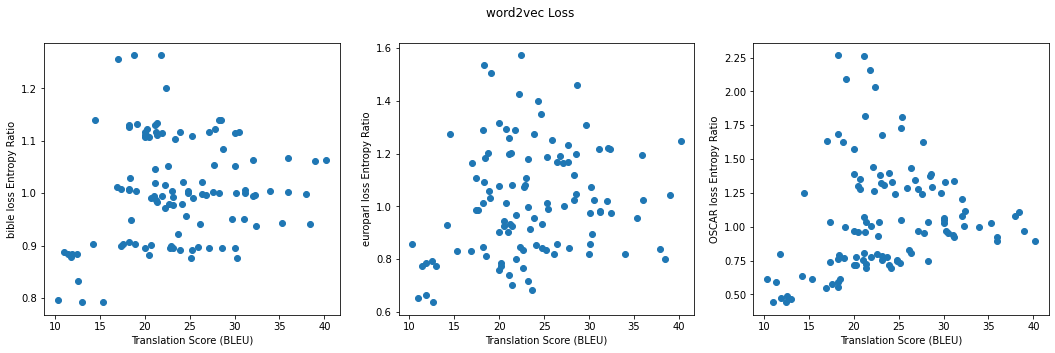

bleu,   bible loss : r= 0.1605471200039503
bleu,   europarl loss : r= 0.18375917921068005
bleu,   OSCAR loss : r= 0.18258265662431097

spbleu, bible loss : r= 0.08162586555402605
spbleu, europarl loss : r= 0.1327758962913351
spbleu, OSCAR loss : r= 0.06693488193741019


In [152]:
entropy_bleu_ratio([('bible loss',bib_los_r),('europarl loss',eur_los_r),('OSCAR loss',osc_los_r),], 'word2vec Loss')

## Plots for Report

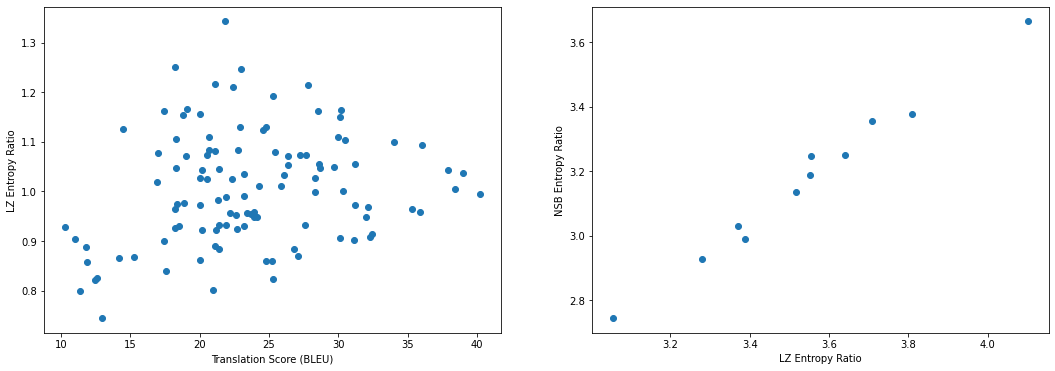

In [172]:
# fig 1
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

ax1.scatter(bleu, lz_bib_r)
ax1.set_xlabel('Translation Score (BLEU)')
ax1.set_ylabel(f'LZ Entropy Ratio')

ax2.scatter([lz_bib_h[l] for l in languages.split()], [nsb_bib_h[l] for l in languages.split()])
ax2.set_xlabel('LZ Entropy Ratio')
ax2.set_ylabel('NSB Entropy Ratio')

plt.show()

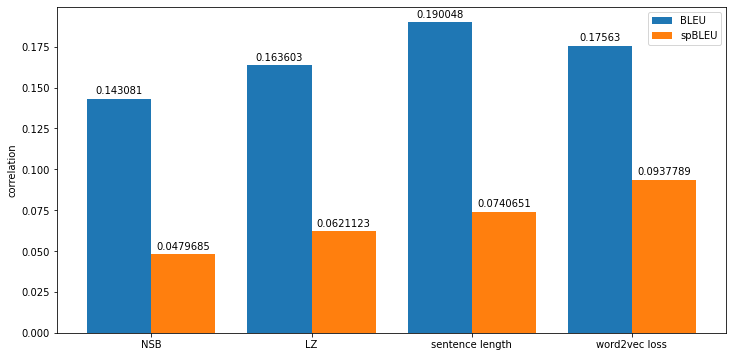

In [181]:
# fig 2
d = [('NSB',[nsb_bib_r, nsb_eur_r, nsb_osc_r]),
     ('LZ',[lz_bib_r, lz_eur_r, lz_osc_r]),
     ('sentence length',[bib_len_r, eur_len_r, osc_len_r]),
     ('word2vec loss',[bib_los_r, eur_los_r, osc_los_r]),
]

nms, bs, spbs = [], [], []
for nm, rs in d:
    b, spb = [], []
    for r in rs:
        b.append(np.corrcoef(bleu, r)[0,1])
        spb.append(np.corrcoef(spbleu, r)[0,1])
    b, spb = sum(b)/len(b), sum(spb)/len(spb)
    
    nms.append(nm)
    bs.append(b)
    spbs.append(spb)

        
fig, ax = plt.subplots(figsize=(12,6))

w = 0.40
x = np.arange(len(nms))

rects1 = ax.bar(x-0.2, bs, w, label='BLEU')
rects2 = ax.bar(x+0.2, spbs, w, label='spBLEU')
ax.set_xticks(x, nms)
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.set_ylabel('correlation')

ax.legend()
plt.show()

In [203]:
# fig 3
x = lambda x: [float(x[l]) for l in languages.split()]
y = lambda x: [1/float(x[l]) for l in languages.split()]
hs = {
    'NSB':x(nsb_bib_h)+x(nsb_eur_h)+x(nsb_osc_h),
    'LZ':x(lz_bib_h)+x(lz_eur_h)+x(lz_osc_h),
    'Len':y(bib_len)+y(eur_len)+y(osc_len),
    'Loss':y(bib_los)+y(eur_los)+y(osc_los),    
}
df_h = pd.DataFrame(hs)
print(df_h.corr().to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &       NSB &        LZ &       Len &      Loss \\
\midrule
NSB  &  1.000000 &  0.392854 &  0.734785 &  0.856160 \\
LZ   &  0.392854 &  1.000000 &  0.458535 &  0.517340 \\
Len  &  0.734785 &  0.458535 &  1.000000 &  0.883985 \\
Loss &  0.856160 &  0.517340 &  0.883985 &  1.000000 \\
\bottomrule
\end{tabular}



## Trying Harder to Recreate Results:

In [116]:
def europarl_sentences_subset(files):
    all_data = []
    for f in files:
        with open(f, 'r') as f:
            data = f.read()

        data = re.sub('<[^<]+?>', '', data) # remove tags

        data = re.sub('[0-9/!?]', '.', data) # end of sentence
        data = re.sub('[0-9/\-\(\):,"]', '', data) # no special chars
        data = data.lower().split('.')
        all_data += data
    return all_data
    
def europarl_words_subset(files):
    text = ' '.join(europarl_sentences_subset(files))
    words = text.split(' ')
    return words

all_files = {}
for lang in languages.split():
    all_files[lang] = _europarl_filenames(lang)
len(all_files['en'])

8123

In [130]:
# fn for getting entropies and entropy ratios
from functools import lru_cache

@lru_cache(maxsize=None)
def calculate_files_entropy(files, n_words=15000):
    corp = europarl_words_subset(files)[:n_words]
    return lz_entropy(corp)

def calculate_files_corr(files):
    r = []
    for l1 in languages.split():
        for l2 in languages.split():
            if l1 != l2:
                h1 = calculate_files_entropy(tuple(files[l1]))
                h2 = calculate_files_entropy(tuple(files[l2]))
                r.append(h2 / h1)
    return np.corrcoef(bleu, r)[0,1]

In [125]:
# correlation distribution
files_per_lang = 2
trials = 15

corrs = []
for _ in range(trials):
    # random files
    files = {l:np.array(all_files[l])[np.random.randint(0,len(all_files[l]), files_per_lang)] for l in languages.split()}
    corrs.append(calculate_files_corr(files))

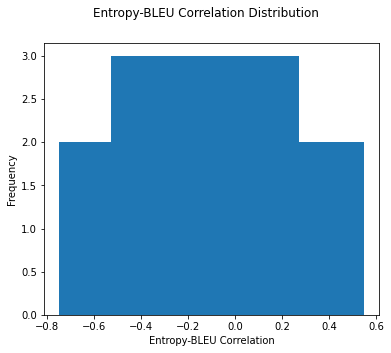

In [128]:
hist, bins = np.histogram(np.array(corrs))

fig, ax = plt.subplots(figsize=(6,5))
ax.bar((bins[1:]+bins[:-1])/2, hist)
ax.set_xlabel('Entropy-BLEU Correlation')
ax.set_ylabel('Frequency')
fig.suptitle("Entropy-BLEU Correlation Distribution")
plt.show()

In [155]:
# correlation hacking
max_files_per_lang = 6
min_files_per_lang = 2
generations = 2000
convergence = 0.5

best = {l:list(np.array(all_files[l])[np.random.randint(0,len(all_files[l]), min_files_per_lang)]) for l in languages.split()}
best_corr = calculate_files_corr(best)

def mutate(files):
    prog = {l:files[l][:] for l in files} # copy files
    langs = languages.split()
    l = langs[np.random.randint(len(langs))] # choose language to mutate
    if (len(prog[l])==min_files_per_lang) or (len(prog[l])<max_files_per_lang and np.random.rand()>0.5): # add file
        prog[l].insert(np.random.randint(len(prog[l])+1), all_files[l][np.random.randint(len(all_files[l]))])
    else: # remove file
        prog[l].pop(np.random.randint(len(prog[l])))
    return prog
    
for g in range(generations):
    prog = mutate(best)
    prog_corr = calculate_files_corr(prog)
    if prog_corr >= best_corr:
        best = prog
        best_corr = prog_corr
    if best_corr >= convergence:
        break
    print(g, best_corr, end='\r')
print(best_corr)

0.342280886568164281642
